# 权重衰退

## 通过限制参数值的选择范围来控制模型容量

$$\min\ l(w,b) \quad subject\ to\ ||w||^2\leq \theta$$

- 通常不限制偏移b（限制不限制的结果差不多）
- 小的$\theta$意味着更强的正则项

## 使用均方范数作为柔性限制

- 对于每个$\theta$，都可以找到$\lambda$使得之前的目标函数等价于下面

$$\min\ l(w,b)+ \frac{\lambda}{2}||w||^2$$
  - 可以通过拉格朗日乘子来证明
- 超参数$\lambda$控制了正则项的重要程度
  - $\lambda=0：无作用$
  - $\lambda\rightarrow \infty ,w^*\rightarrow 0$

## 参数更新法则
- 计算梯度$$\frac{\partial}{\partial w}(l(w,b)+\frac{\lambda}{2}||w||^2)=\frac{\partial l(w,b)}{\partial w}+\lambda w$$
- 时间更新参数$$w_{t+1}=(1-\eta \lambda)w_t-\eta \frac{\partial l(w_t,b_t)}{\partial w_t}$$
  - 通常$\eta\lambda<1,在深度学习中通常叫做权重衰退$

# 从零开始实现

权重衰退是最广泛使用的正则化的技术之一

In [1]:
%matplotlib inline
import torch
from torch import nn
import d2l_source.d2l as d2l

生成数据

$$y=0.05+\sum^{d}_{i=1}{0.01x_i} +\epsilon\quad where\quad\epsilon \sim N(0,0.01^2)$$

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

随机化模型参数

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

$L_1$范数惩罚

In [4]:
def l1_penalty(w):
    return torch.sum(torch.abs(w))

$L_2$范数惩罚

In [5]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

训练（L2）

In [6]:
def train2(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

训练（L1）

In [9]:
def train1(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L1范数惩罚项，
            # 广播机制使l1_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l1_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L1范数是：', torch.norm(w).item())

忽略正则化训练

过拟合

w的L1范数是： 12.788636207580566


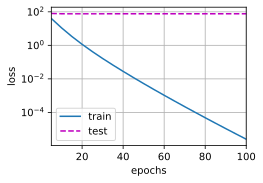

In [10]:
train1(lambd=0)

w的L2范数是： 11.960397720336914


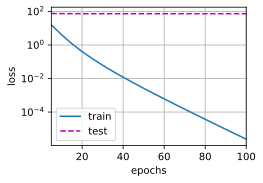

In [11]:
train2(lambd=0)

使用权重衰减

w的L1范数是： 0.07633686065673828


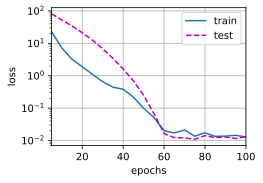

In [12]:
train1(lambd=3)

w的L2范数是： 0.3874984383583069


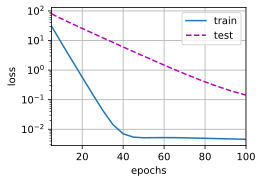

In [13]:
train2(lambd=3)

w的L1范数是： 0.2512568235397339


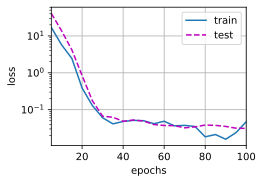

In [14]:
train1(lambd=10)

w的L2范数是： 0.028405150398612022


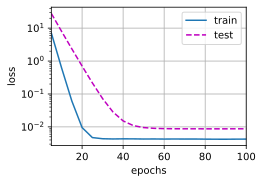

In [15]:
train2(lambd=10)

# 简洁实现

In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.559860229492188


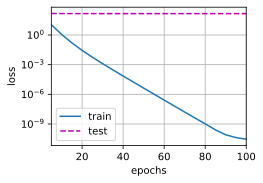

In [10]:
train_concise(0)

w的L2范数： 0.36086079478263855


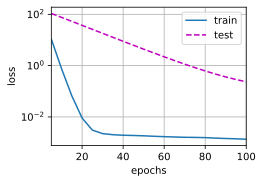

In [11]:
train_concise(3)